In [1]:
import os
import shutil
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [4]:
def split_data(dataset_dir, train_dir, val_dir, test_dir, split_ratio=(0.8, 0.1, 0.1)):
    # If the directory already exists, delete it
    for directory in [train_dir, val_dir, test_dir]:
        if os.path.exists(directory):
            shutil.rmtree(directory)

    # Create the directory if it does not exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Collect the filenames
    image_files = os.listdir(dataset_dir)
    random.shuffle(image_files)

    # Split the data
    total_images = len(image_files)
    num_train = int(total_images * split_ratio[0])
    num_val = int(total_images * split_ratio[1])
    num_test = total_images - num_train - num_val

    # Copy the images to the correct directory
    for i, image_file in enumerate(image_files):
        src_path = os.path.join(dataset_dir, image_file)
        if i < num_train:
            dst_path = os.path.join(train_dir, image_file)
        elif i < num_train + num_val:
            dst_path = os.path.join(val_dir, image_file)
        else:
            dst_path = os.path.join(test_dir, image_file)
        shutil.copy(src_path, dst_path)

    print("Splitting data completed.")

In [6]:
# Define paths
black_pod_rot_SRC_DIR = "data/black_pod_rot"
monilia_SRC_DIR = "data/monilia"
healthy_SRC_DIR = "data/healthy"

TRAINING_DIR = "dataset/training"
VALIDATION_DIR = "dataset/validation"
TEST_DIR = "dataset/test"

TRAINING_BPR_DIR = os.path.join(TRAINING_DIR, "black_pod_rot/")
VALIDATION_BPR_DIR = os.path.join(VALIDATION_DIR, "black_pod_rot/")
TEST_BPR_DIR = os.path.join(TEST_DIR, "black_pod_rot/")

TRAINING_M_DIR = os.path.join(TRAINING_DIR, "monilia/")
VALIDATION_M_DIR = os.path.join(VALIDATION_DIR, "monilia/")
TEST_M_DIR = os.path.join(TEST_DIR, "monilia/")

TRAINING_HEALTHY_DIR = os.path.join(TRAINING_DIR, "healthy/")
VALIDATION_HEALTHY_DIR = os.path.join(VALIDATION_DIR, "healthy/")
TEST_HEALTHY_DIR = os.path.join(TEST_DIR, "healthy/")

# Define proportion of images used for training
train_size = 0.8
val_size = 0.1
test_size = 0.1

split_data(black_pod_rot_SRC_DIR,
           TRAINING_BPR_DIR,
           VALIDATION_BPR_DIR,
           TEST_BPR_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(healthy_SRC_DIR,
           TRAINING_HEALTHY_DIR,
           VALIDATION_HEALTHY_DIR,
           TEST_HEALTHY_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(monilia_SRC_DIR,
           TRAINING_M_DIR,
           VALIDATION_M_DIR,
           TEST_M_DIR,
           split_ratio=(train_size,val_size, test_size))

Splitting data completed.
Splitting data completed.
Splitting data completed.


In [7]:

print(f"\n\nOriginal Black Pod Rot directory has {len(os.listdir(black_pod_rot_SRC_DIR))} images")
print(f"Original Healthy directory has {len(os.listdir(healthy_SRC_DIR))} images")
print(f"Original Monilia directory has {len(os.listdir(monilia_SRC_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_BPR_DIR))} images of Black Pod Rot for training")
print(f"There are {len(os.listdir(TRAINING_HEALTHY_DIR))} images ofHealthy for training")
print(f"There are {len(os.listdir(TRAINING_M_DIR))} images of Monilia for training\n")

print(f"There are {len(os.listdir(VALIDATION_BPR_DIR))} images of Black Pod Rot for validation")
print(f"There are {len(os.listdir(VALIDATION_HEALTHY_DIR))} images of Healthy for validation")
print(f"There are {len(os.listdir(VALIDATION_M_DIR))} images of Monilia for validation\n")

print(f"There are {len(os.listdir(TEST_BPR_DIR))} images of Black Pod Rot for test")
print(f"There are {len(os.listdir(TEST_HEALTHY_DIR))} images of Healthy for test")
print(f"There are {len(os.listdir(TEST_M_DIR))} images of Monilia for test")



Original Black Pod Rot directory has 943 images
Original Healthy directory has 3344 images
Original Monilia directory has 105 images

There are 754 images of Black Pod Rot for training
There are 2675 images ofHealthy for training
There are 84 images of Monilia for training

There are 94 images of Black Pod Rot for validation
There are 334 images of Healthy for validation
There are 10 images of Monilia for validation

There are 95 images of Black Pod Rot for test
There are 335 images of Healthy for test
There are 11 images of Monilia for test


In [15]:
# Copiar archivos de una carpeta a otra
def copyfile(src, dst):
    shutil.copyfile(src, dst)
width = 250
height = 250
# Crear un generador de imágenes
image_transforms = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.ToTensor(),
])

# Directorio de datos de entrenamiento
train_data_dir = "dataset/training"
train_dataset = ImageFolder(train_data_dir, transform=image_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Directorio de datos de validacion
valid_data_dir = "dataset/validation"
valid_dataset = ImageFolder(valid_data_dir, transform=image_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Directorio de datos de entrenamiento
test_data_dir = "dataset/test"
test_dataset = ImageFolder(test_data_dir, transform=image_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
train_loader

<AxesSubplot:>

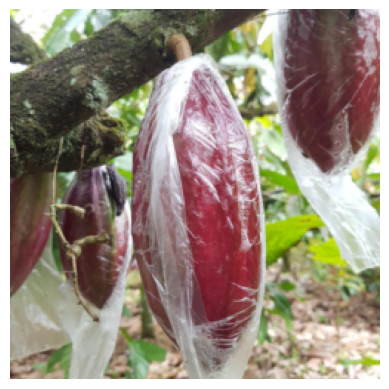

In [16]:
#print one image on train loader
import helper
images, labels = next(iter(train_loader))
helper.imshow(images[0], normalize=False)

In [17]:
#Definir el modelo
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(128 * 31 * 31, 32) 
        self.dropout1 = nn.Dropout(p=0.25) 
        self.fc2 = nn.Linear(32, 3)
        self.dropout2 = nn.Dropout(p=0.25)
        
        self.bn_fc1 = nn.BatchNorm1d(32)
        self.bn_fc2 = nn.BatchNorm1d(3)

    def forward(self, x):
        # Pasada a través de las capas convolucionales y pooling
        x = self.pool1(self.bn1(self.relu(self.conv1(x))))
        x = self.pool2(self.bn2(self.relu(self.conv2(x))))
        x = self.pool3(self.bn3(self.relu(self.conv3(x))))
        
        x = x.view(-1, 128 * 31 * 31)  # aplanar el tensor
        
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.bn_fc1(x)
        
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn_fc2(x)
        return x


In [18]:
# Instanciar el modelo
model = CustomModel()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Entrenamiento del modelo
num_epochs = 20

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
for epoch in range(1, num_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'cacao_disease.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.680486 	Validation Loss: 0.575708
Validation loss decreased (inf --> 0.575708).  Saving model ...


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
    train_datagen = ImageDataGenerator(
                                    rescale=1. / 255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
                                     )
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=10,
                                                      class_mode='categorical',
                                                      target_size=(250,250))
    validation_datagen = ImageDataGenerator(rescale=1.0/255)
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=10,
                                                                class_mode='categorical',
                                                                target_size=(250,250))
    test_datagen = ImageDataGenerator(rescale=1.0/255)
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=10,
                                                                class_mode='categorical',
                                                                target_size=(250,250),
                                                                shuffle=False)
    return train_generator, validation_generator, test_generator


In [ ]:
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

In [ ]:
# Print label
class_labels = train_generator.class_indices
print(class_labels)

In [ ]:
import gradio as gr

# Primero, definimos una función de predicción que utilizará nuestro modelo.
def predict_image(img):
    # Convierte la imagen a PyTorch Tensor y agrega una dimensión adicional
    img_tensor = transforms.ToTensor()(img).unsqueeze(0)
    
    # Haz la predicción con tu modelo
    with torch.no_grad():
        model.eval()
        prediction = model(img_tensor)

    # Extrae las probabilidades, aplica softmax y devuelve la clase con mayor probabilidad
    probabilities = torch.nn.functional.softmax(prediction[0], dim=0)
    class_index = class_labels[torch.argmax(probabilities).item()]

    return class_index  # aquí puedes mapear el índice de clase a una etiqueta de clase si lo deseas

# Luego, creamos la interfaz de Gradio
iface = gr.Interface(fn=predict_image, 
                     inputs=gr.inputs.Image(shape=(height, width)), 
                     outputs="text")

# Finalmente, lanzamos la interfaz
iface.launch()


In [ ]:
from tensorflow.keras.optimizers import Adam
def create_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(250,250,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [ ]:
model = create_model()
model.summary()

In [ ]:
#Train


# create checkpoint
checkpoint = ModelCheckpoint('model_tertinggi.h5', monitor='accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

In [ ]:
# Mendapatkan satu batch gambar dari train_generator
batch = train_generator.next()

# Mendapatkan array gambar dan labelnya dari batch
images = batch[0]
labels = batch[1]

# Memilih indeks acak untuk menampilkan gambar
random_index = np.random.randint(0, images.shape[0])

# Mengambil gambar dan label dengan indeks acak
image = images[random_index]
label = labels[random_index]

# Menampilkan gambar
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot train loss dan validation loss
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

# Fungsi untuk melakukan prediksi pada file gambar
def predict_image(file):
    img = image.load_img(file, target_size=(250, 250))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    prediction = model_terbaik.predict(img)
    predicted_class_index = np.argmax(prediction)
    predicted_probability = np.max(prediction)

    return predicted_class_index, predicted_probability

#file
uploaded_file = '/kaggle/input/test-data/test cocoa/black_pod_rot/black_pod_rot_94.jpg'

#prediksi pada file gambar
predicted_class_index,  predicted_probability = predict_image(uploaded_file)

if predicted_class_index == 0:
    hasil = 'Back Pod Rot'
elif predicted_class_index == 1:
    hasil = 'Healthy'
else:
    hasil = 'Pod Borer'

print("Hasil prediksi:", hasil)
print("Probabilitas prediksi:", predicted_probability)



In [ ]:

from sklearn.metrics import classification_report

# Mengumpulkan prediksi model untuk data uji
y_pred = model_terbaik.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Mengambil label sebenarnya dari generator
y_true_labels = test_generator.classes

# Mendapatkan nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

# Membuat classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

# Menampilkan classification report
print(report)


In [ ]:
y_true_labels

In [ ]:
y_pred_labels

**For Deploying**

In [ ]:
# pip install tensorflowjs